In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import os
import financial.data as fd
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory
from financial.io.file.cache import FileCache

In [177]:
cache = os.environ["CACHE"]
datastore = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=cache+"/"))
print(datastore)                

CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


In [178]:
import financial.model as fm
import financial.lab.models as labmodels
import sklearn.linear_model

class LinearScikitLearnModelFactory (labmodels.ModelFactory):
    '''
    Linear regression Scikit-Learn model factory
    '''
        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()

In [179]:
start_date = "1990-01-01"
end_date = "2023-12-31"
ticker = "^GSPC"

config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}

In [180]:
experiment_linear = ModelExperimentFactory.create_experiment(config)
experiment_linear.run()
print(experiment_linear.predictions)

1990-05-10   -0.002445
1990-05-11    0.000419
1990-05-14    0.000412
1990-05-15   -0.002300
1990-05-16   -0.001051
                ...   
2023-12-22   -0.003897
2023-12-26   -0.002925
2023-12-27    0.000292
2023-12-28    0.000937
2023-12-29    0.000158
Length: 8475, dtype: float64


In [181]:
absolute_predictions_linear = experiment_linear.reconstruct_absolute_predictions_from_relative()

In [182]:
import pickle
path = os.path.join(cache, f"{config["name"]}.pickle")
with open(path, 'rb') as file:
    predictions = pickle.load(file)
print(predictions)

path = os.path.join(cache, f"{config["name"]}.results.{config["ticker"]}.train.pickle")
with open(path, 'rb') as file:
    predictions_train = pickle.load(file)
print(predictions_train)

path = os.path.join(cache, f"{config["name"]}.results.{config["ticker"]}.test.pickle")
with open(path, 'rb') as file:
    predictions_test = pickle.load(file)
print(predictions_test)

LinearRegression()
global_first_experiment.^GSPC.train
global_first_experiment.^GSPC.test


In [183]:
from financial.momentum.models.randomForest import RandomForestModelFactory

factory = RandomForestModelFactory()
config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_forest_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}


In [184]:
experiment_forest = ModelExperimentFactory.create_experiment(config)
experiment_forest.run()

In [185]:
import pickle
path = os.path.join(cache, f"{config["name"]}.pickle")
with open(path, 'rb') as file:
    predictions = pickle.load(file)
print(experiment_forest.predictions)

1990-05-10   -0.032211
1990-05-11   -0.017100
1990-05-14   -0.023136
1990-05-15   -0.023589
1990-05-16   -0.024339
                ...   
2023-12-22   -0.034491
2023-12-26   -0.028145
2023-12-27   -0.033929
2023-12-28   -0.029042
2023-12-29   -0.031123
Length: 8475, dtype: float64


In [186]:
stdev = experiment_forest.target[0].stdev
mean = experiment_forest.target[0].mean
deconstructed_predictions = (experiment_forest.predictions /stdev) - mean

import pandas as pd

def reconstruct_relative(data: pd.Series, model_output: pd.Series) -> pd.Series:
    #print(model_output[:-lookahead])
    reconstructed_change = - (mean+stdev*model_output) # Sign reversal @ shift(-lookahead)
    #print("reconstructed change")
    #print(reconstructed_change[:-lookahead]) 
    # change = (final-inicial)/final => change*final = final-inicial => final = inicial/(1-change)
    reconstructed_final = data / (1-reconstructed_change)
    #print("reconstructed final")
    #print(reconstructed_final[:-lookahead].dropna()) 
    return reconstructed_final.shift(20).dropna()

data = datastore.get_data(ticker, start_date, end_date)
print(reconstruct_relative(data, deconstructed_predictions))

1990-06-08     357.053944
1990-06-11     359.901037
1990-06-12     364.965050
1990-06-13     364.651509
1990-06-14     364.644755
                 ...     
2023-12-22    4744.131110
2023-12-26    4742.350664
2023-12-27    4764.349083
2023-12-28    4741.384502
2023-12-29    4752.590185
Length: 8455, dtype: float64


In [187]:
print(data)

1990-01-02     359.690002
1990-01-03     358.760010
1990-01-04     355.670013
1990-01-05     352.200012
1990-01-08     353.790009
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: ^GSPC, Length: 8565, dtype: float64


In [188]:
absolute_predictions_forest = experiment_forest.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions)

1990-06-08     355.263385
1990-06-11     358.123947
1990-06-12     363.151821
1990-06-13     362.838997
1990-06-14     362.830883
                 ...     
2023-12-22    4720.293686
2023-12-26    4718.484680
2023-12-27    4740.285199
2023-12-28    4717.528999
2023-12-29    4728.711976
Length: 8455, dtype: float64


In [189]:
from financial.momentum.models.SVR import SVRModelFactory

factory = SVRModelFactory()
config = {
    "mode": "global",
    "datastore": datastore,
    "ticker": ticker,
    "model_factory": factory,
    "name": "global_svr_first_experiment",
    "start_year": start_date,
    "end_year": end_date
}

In [190]:
experiment_svr = ModelExperimentFactory.create_experiment(config)
experiment_svr.run()
print(experiment_svr.predictions)

1990-05-10   -0.016429
1990-05-11   -0.022004
1990-05-14   -0.023297
1990-05-15   -0.025132
1990-05-16   -0.024495
                ...   
2023-12-22   -0.037732
2023-12-26   -0.037739
2023-12-27   -0.037491
2023-12-28   -0.037746
2023-12-29   -0.039478
Length: 8475, dtype: float64


In [191]:
absolute_predictions_svr = experiment_svr.reconstruct_absolute_predictions_from_relative()
print(absolute_predictions_svr)

1990-06-08     349.563133
1990-06-11     359.919757
1990-06-12     363.211850
1990-06-13     363.413385
1990-06-14     362.889009
                 ...     
2023-12-22    4610.048728
2023-12-26    4604.692539
2023-12-27    4600.523096
2023-12-28    4587.123828
2023-12-29    4596.469585
Length: 8455, dtype: float64


In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__
style.use('ggplot')
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for i, serie in enumerate(series):
            linewidth = 1.0  # Grosor de línea predeterminado
            if i == 0:  # Si es la primera serie en la lista (índice 0)
                linewidth = 3.0  # Grosor de línea mayor
            serie[start_date:end_date].plot(linewidth=linewidth)

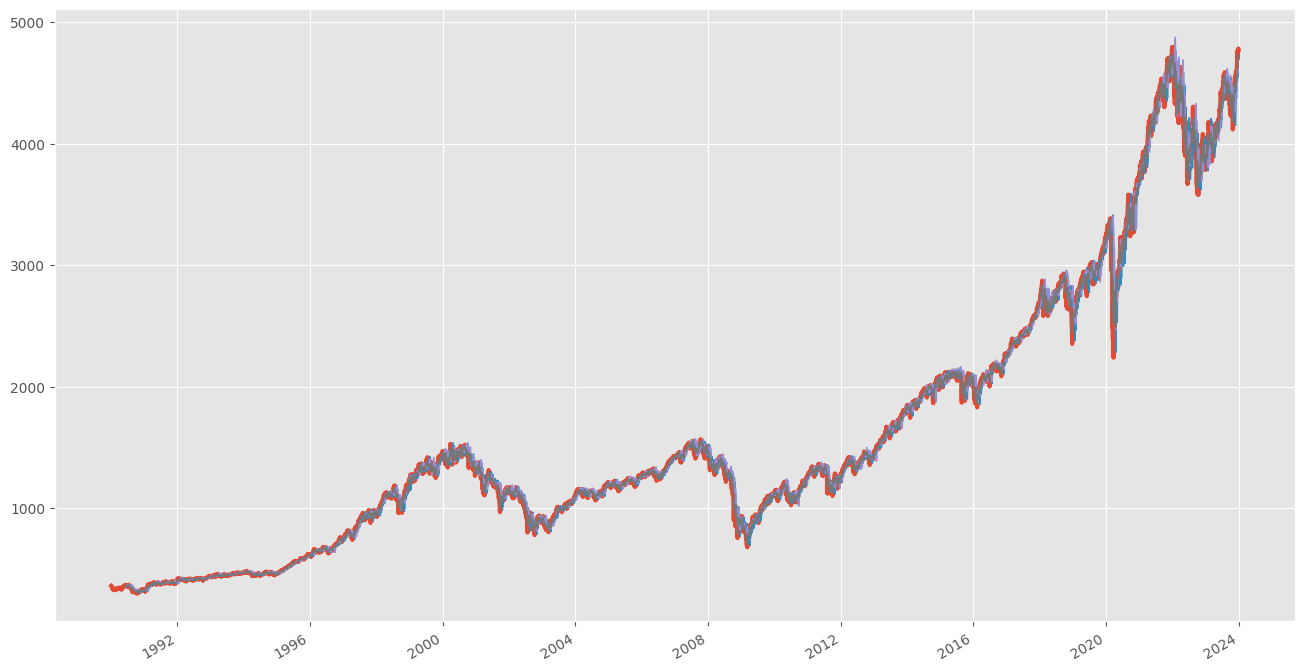

In [193]:
plot_series([data, absolute_predictions_linear, absolute_predictions_svr, absolute_predictions_forest])

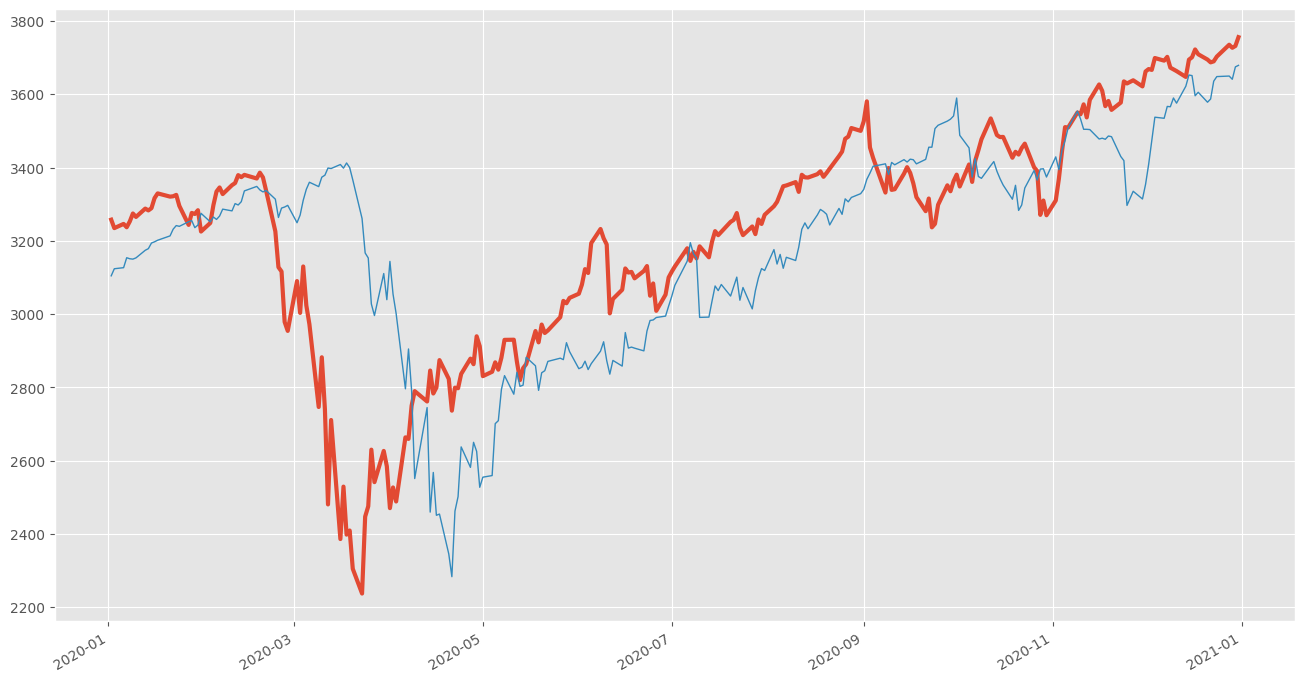

In [194]:
plot_series([data, absolute_predictions_linear], "2020-01-01", "2021-01-01")

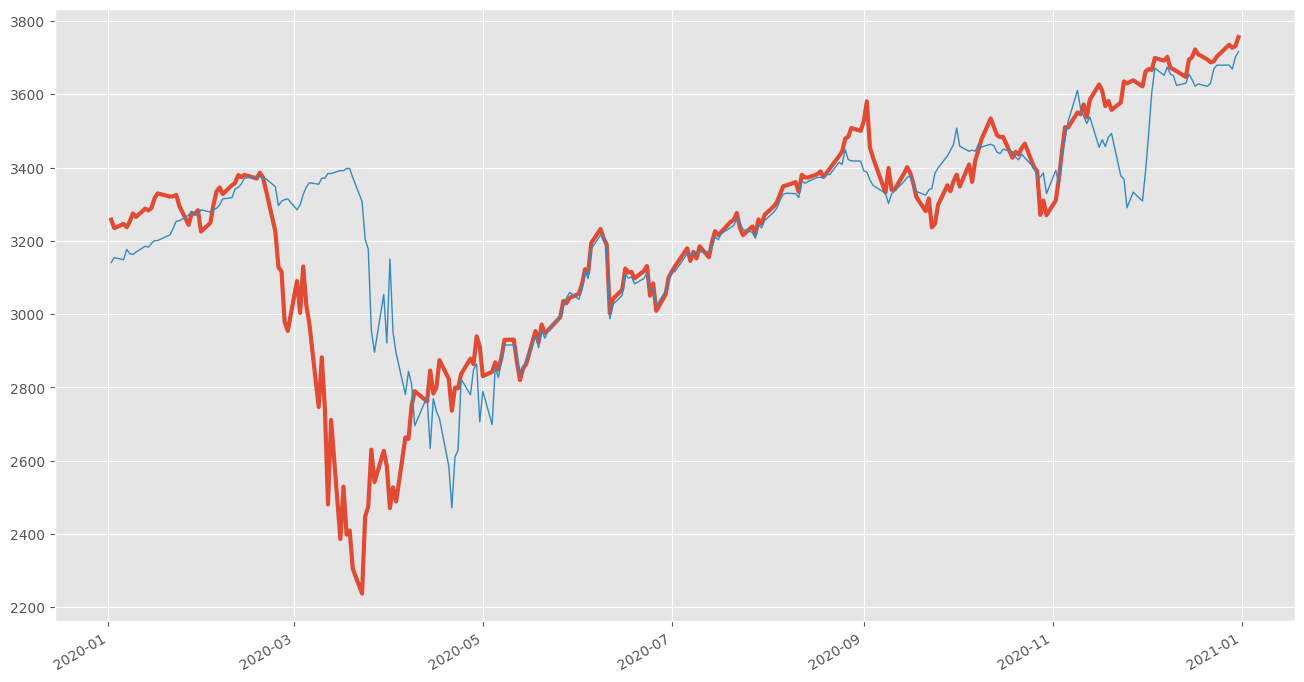

In [195]:
plot_series([data, absolute_predictions_svr], "2020-01-01", "2021-01-01")

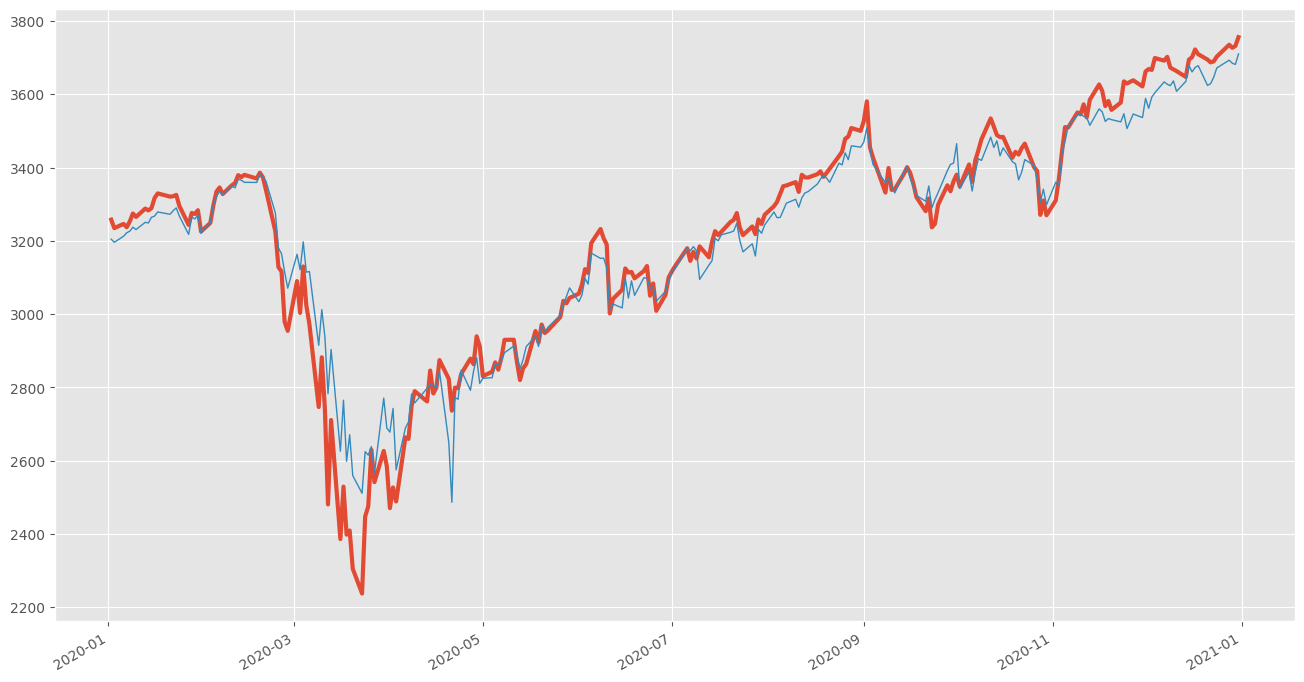

In [196]:
plot_series([data, absolute_predictions_forest], "2020-01-01", "2021-01-01")

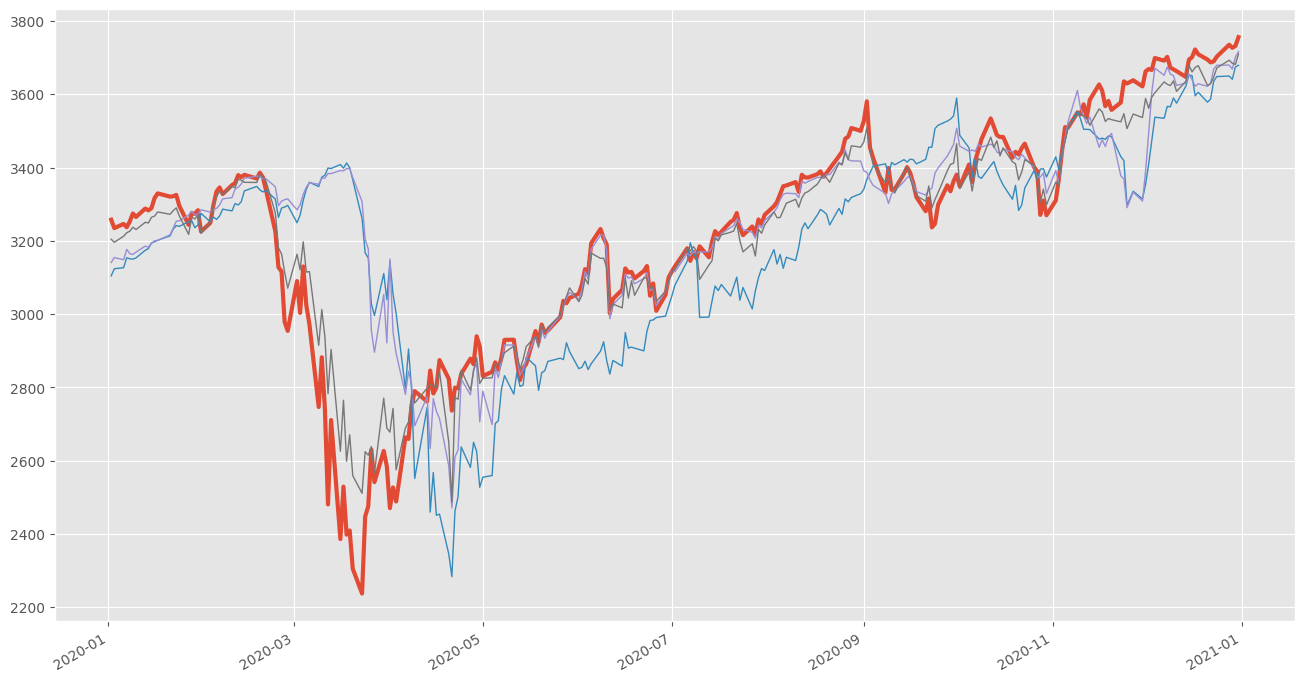

In [197]:
plot_series([data, absolute_predictions_linear, absolute_predictions_svr, absolute_predictions_forest], "2020-01-01", "2021-01-01")

In [198]:
print(experiment_svr.predictions.size)
print(absolute_predictions_svr.size)
print(data.size)
target = data[20+90:]
print(target.size)
from financial.lab.experiment import Experiment
from sklearn.metrics import r2_score

8475
8455
8565
8455


In [199]:
metrics_linear = Experiment(experiment_linear.name, absolute_predictions_linear, target)
r2 = r2_score(target, absolute_predictions_linear)

print("GLOBAL:")
print(f"n={metrics_linear.samples()} MSE={metrics_linear.MSE():.4f} RMSE={metrics_linear.RMSE():.4f} MAE={metrics_linear.MAE():.4f} MAPE={metrics_linear.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_linear.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_linear.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8455 MSE=7681.6077 RMSE=87.6448 MAE=52.2052 MAPE=0.0323 R² = 0.9935
TRAIN: 
n=62696 MSE=0.9353 RMSE=0.9669 MAE=0.6837 MAPE=3.0168
TEST: 
n=13579 MSE=1.3079 RMSE=1.1374 MAE=0.8020 MAPE=1.2312


In [200]:
metrics_svr = Experiment(experiment_svr.name, absolute_predictions_svr, target)
r2 = r2_score(target, absolute_predictions_svr)

print("GLOBAL:")
print(f"n={metrics_svr.samples()} MSE={metrics_svr.MSE():.4f} RMSE={metrics_svr.RMSE():.4f} MAE={metrics_svr.MAE():.4f} MAPE={metrics_svr.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_svr.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_svr.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8455 MSE=5754.0218 RMSE=75.8553 MAE=41.0339 MAPE=0.0257 R² = 0.9951
TRAIN: 
n=62696 MSE=0.6725 RMSE=0.8196 MAE=0.5349 MAPE=7.1282
TEST: 
n=13579 MSE=1.3441 RMSE=1.1530 MAE=0.7843 MAPE=2.4948


In [201]:
metrics_forest = Experiment(experiment_svr.name, absolute_predictions_forest, target)
r2 = r2_score(target, absolute_predictions_forest)

print("GLOBAL:")
print(f"n={metrics_forest.samples()} MSE={metrics_forest.MSE():.4f} RMSE={metrics_forest.RMSE():.4f} MAE={metrics_forest.MAE():.4f} MAPE={metrics_forest.MAPE():.4f} R² = {r2:.4f}")

print("TRAIN: ")
results = experiment_forest.train
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

print("TEST: ")
results = experiment_forest.test
print(f"n={results.samples()} MSE={results.MSE():.4f} RMSE={results.RMSE():.4f} MAE={results.MAE():.4f} MAPE={results.MAPE():.4f}")

GLOBAL:
n=8455 MSE=716.9289 RMSE=26.7755 MAE=15.6801 MAPE=0.0096 R² = 0.9994
TRAIN: 
n=62696 MSE=0.0848 RMSE=0.2911 MAE=0.1992 MAPE=3.8924
TEST: 
n=13579 MSE=1.5015 RMSE=1.2173 MAE=0.8481 MAPE=2.0352
